# K-means Cluster Analysis and WordCloud Visualisation

## Overview
<span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'> The k-means analysis works by grouping items by comparing their similarity to a predefined number of centroids; each data point is grouped to the nearest centroid, eventually forming clusters around these centroids (Goel, 2018).

## Rationale
<span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>  A k-means cluster analysis was deemed appropriate because in this instance, for simplicity, we have assumed two genders: male and female. Because we have made this assumption, we can specify k = 2, and see how similar or different the two clusters are. We can also use the 'elbow method' to determine the actual optimum number of clusters. This can tell us about the language relating to men and women in STEM, if the language differs and how.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import pickle
import seaborn as sns
from textblob import TextBlob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 

In [2]:
# Read the dataset
df = pd.read_csv("tweets_df.csv")
df["Tweet"] = df["Text"]
df = df[["Tweet", "Gender"]]
df = df.replace(to_replace = "F", value = 1)
df = df.replace(to_replace = "M", value = 0)


# Remove 'science', 'technology', 'engineering' and 'math' and replace with ' '
words_to_remove = ['science', 'scientist', 'technology', 'technologist', 'engineering', 'engineer', 'mathematics', 'mathematician', 'math']
df['Tweet'] = df.Tweet.str.replace('|'.join(words_to_remove), '', regex=True).str.strip()



df.head(10)

,Tweet,Gender
0,and 17 othersSorry to interrupt he Good Mornin...,0
1,Seongmin didnt attend a tutoring academy but h...,0
2,and 2 othersMaybe it a lack of education mayb...,0
3,I’m so glad my bf is smartso he can do my hw ...,0
4,Meet Gena Johnson who has worked with John Pri...,1
5,Fauci is not a He is a self serving politica...,0
6,worked for an electric bike co in 2003 The at...,0
7,moms forcing me to take when she knows its my...,1
8,quote Buttigieg claimed he meant to say that p...,0
9,URI ENGage Alumni Spotlight returns with Kenny...,0


## Data Pre-Processing
<span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>  The cleaned Tweets dataset required further processing before applying NLP tasks.
<span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'> 
  * <span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>1.	Conversion of ‘M’ and ‘F’ classes to ‘0’ and ‘1’.
  * <span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>2.	Specification of X as Tweet ‘Text’ and y as gender/‘Target’.
  * <span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>3.	Lemmatization, to group different forms of similar words, to be analysed as a single term.
  * <span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>4.	Vectorisation, to remove English stop words and convert words to numbers, allowing computation of language data.
  * <span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>5.	Tfidf transformation, to assign a weighting to each word, weigh the frequency of each term (TF) within a corpus and multiply it by the inverse document frequency (IDF), reducing the weighting of common words (Goel, 2018).

<span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>  The dataset was then split into a train set and a test set, containing 80% and 20% of the data, respectively. Because the dataset is so imbalanced, the paramater stratify = y was used to ensure that, in both the train and test sets, the proportion of male and female Tweets remained the same as in the original dataset (Kreiger, 2020). 



In [3]:
X = df.iloc[:,0:].values
y = df.iloc[:,1:].values

In [4]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen])) 
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)   
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)   
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)   
    # Converting to Lowercase
    document = document.lower()  
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [5]:
# Create vocabularies
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()

In [6]:
# Split train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

## The 'Elbow method'

<span  style='font-size:20px'><span  style='font-family:"Arial'><span style=''><span  style='line-height:1.5'>  <i>Figure 6</i> shows the results of the 'Elbow Method' of determining a value k, corresponding to the possible number of clusters in the dataset. There is an 'elbow' at k=7, suggesting that this is the optimal number of clusters. This is contrary to expectations that there may be two clusters, corresponding to gender. The word clouds below show that at <b>k = 2</b>, there is considerable overlap in the most common words in both clusters. This suggests that the bias in STEM Tweets is not due to bias in the language used to describe men and women in STEM, but rather due to the representation bias towards men. 

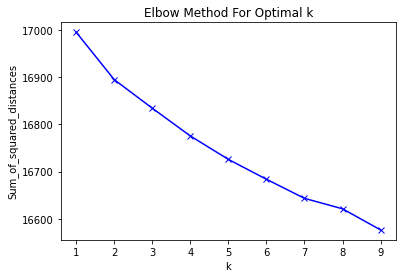

In [7]:
# Perform Kmeans cluster analysis
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# k = 2

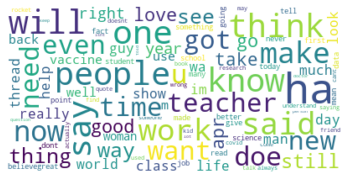

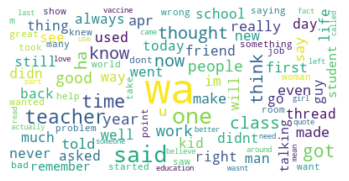

In [8]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
tweet_cl=pd.DataFrame(list(zip(document,labels)),columns=['Tweet','cluster'])

from wordcloud import WordCloud
result={'cluster':labels,'wiki':documents}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    titles=tweet_cl[tweet_cl.cluster==k]['Tweet']  
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()